In [1]:
from dataset import SequenceDataset
from model import LSTM
from main import *
from torch.utils.data import DataLoader
from utils import *
import pandas as pd
import torch
import numpy as np
import random
import xgboost as xgb

In [2]:
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

In [3]:
df = pd.read_csv(r'F:\ML_Bootcamp\LTSF-Linear\dataset\test.csv')
df = preprocess_data(df)

In [4]:
target = 'Close'
features = list(df.columns)

In [5]:
train_size = int(len(df)*.8)
train_df = df[:train_size]
test_df = df[train_size:]

In [6]:
scaled_train_df, scalers = scale_df(train_df)
scaled_test_df = apply_scalers(test_df, scalers)
train_dataset = SequenceDataset(scaled_train_df, target, features)
test_dataset = SequenceDataset(scaled_test_df, target, features)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [7]:
n_epochs = 5 # 5 epochs
learning_rate = 0.001 # 0.001 lr
lstm = LSTM()

In [8]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
train(n_epochs=n_epochs,
              model=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              train_loader=train_loader)

batch #: 0, current average train loss: 0.21484
batch #: 20, current average train loss: 0.12625
batch #: 40, current average train loss: 0.07323
batch #: 60, current average train loss: 0.05315
batch #: 80, current average train loss: 0.04160
Epoch: 0, train loss: 0.03508
batch #: 0, current average train loss: 0.00109
batch #: 20, current average train loss: 0.00444
batch #: 40, current average train loss: 0.00455
batch #: 60, current average train loss: 0.00466
batch #: 80, current average train loss: 0.00476
Epoch: 1, train loss: 0.00500
batch #: 0, current average train loss: 0.00602
batch #: 20, current average train loss: 0.00447
batch #: 40, current average train loss: 0.00411
batch #: 60, current average train loss: 0.00382
batch #: 80, current average train loss: 0.00395
Epoch: 2, train loss: 0.00396
batch #: 0, current average train loss: 0.00101
batch #: 20, current average train loss: 0.00341
batch #: 40, current average train loss: 0.00344
batch #: 60, current average tra

In [9]:
X_train_0, y_train_0 = supervised_from_dataframe(scaled_train_df, target, features, sequence_length=21, pred_length=7)
X_test_0, y_test_0 = supervised_from_dataframe(scaled_test_df, target, features, sequence_length=21, pred_length=7)

In [10]:
train_loader_2 = DataLoader(train_dataset, batch_size=8, shuffle=False)
train_preds = predict(lstm, train_loader_2)

In [11]:
train_preds = train_preds.numpy()

In [12]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=2000, learning_rate=0.005)

In [13]:
model.fit(train_preds, y_train_0)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.005, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [14]:
test_preds = predict(lstm, test_loader)

In [15]:
xgb_test_preds = model.predict(test_preds)

In [16]:
preds = torch.Tensor(xgb_test_preds)

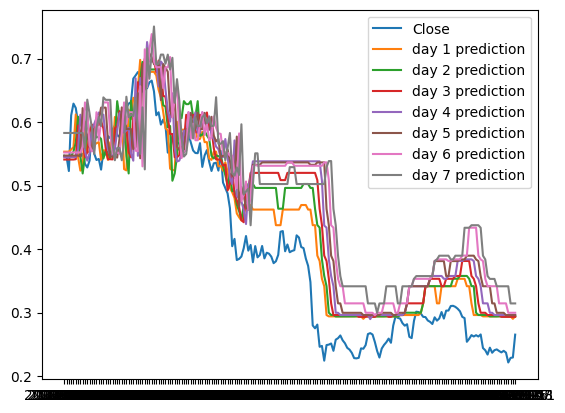

In [17]:
plot_test(scaled_test_df, preds)